In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os
import time
import pandas as pd
import numpy as np

import mne
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.decoding import GeneralizingEstimator, SlidingEstimator, cross_val_multiscore

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, KMeans

from scipy.stats import spearmanr

import multiprocess as mp
import dill
# Required for multiprocess to work in Jupyter notebook
dill.settings['recurse'] = True

from functools import partial

import spacy

In [3]:
T_LIMIT = None

def cutoff(n_times):
    if T_LIMIT:
        return min(n_times, T_LIMIT)
    else:
        return n_times

In [4]:
@ignore_warnings(category=ConvergenceWarning) # So scikit wont print thousands of convergence warnings
def get_perf_timecourse(X, y, decoder, perf_metric, n_splits=5):
    n_times = X.shape[-1]
    scores = np.zeros(n_times)
    kf = StratifiedKFold(n_splits, shuffle=True)
    
    for t in range(cutoff(n_times)):
        t_scores = []

        for train_indices, test_indices in kf.split(X, y):
            decoder = decoder.fit(X[train_indices, :, t], y[train_indices])
            y_pred = decoder.predict_proba(X[test_indices, :, t])[:,1]

            score = perf_metric(y[test_indices], y_pred)
            #acc = decoder.score(X[train_indices, :, t], y[train_indices])
            t_scores.append(score)
        
        scores[t] = sum(t_scores) / len(t_scores)

        print(f"Score is {round(scores[t], 3)} at t={t}", end="\r")

    return scores


In [5]:
def as_df(x, y):
    return pd.DataFrame({'x': x, 'y': y})

In [6]:
nlp = spacy.load('en_core_web_sm')

def get_pos(sentence):
    words = sentence.split(' ')
    doc = nlp(sentence)
    pos = []
    
    i = -1
    
    for token in doc:
        in_current_word = token.text in words[i]
        
        if i + 1 < len(words):
            in_current_word = in_current_word and token.text not in words[i + 1]
        
        if in_current_word and i > 0:
            pos[i] = token.pos_
        else:
            i += 1
            pos.append(token.pos_)

    return pos

def get_pos_col(word_info):
    full_text = ' '.join(word_info['word'].tolist())
    return pd.Series(get_pos(full_text))
    # sentences = word_info.groupby(["wav_file", "sentence_number"])["word"].agg(lambda words: ' '.join(words))
    # # Get POS and flatten grouped values into a list
    # pos = np.concatenate(sentences.apply(get_pos).values)
    # return pos

def get_data(sub_id, segment='phoneme'):
    fif_name = 'start_phoneme_-1000_-1000_dcm10_BLNone_hpf60_rep0-epo.fif'
    features = ['phoneme', 'phonation', 'manner', 'place', 'frontback', 'roundness', 'centrality']
    
    if segment == 'word':
        fif_name = 'start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo.fif'
        features = ['pos']

    base_path = f'./story_sub_data/{sub_id}/{segment}_epochs'

    fif = mne.read_epochs(f'{base_path}/{fif_name}')
    
    metadata = pd.read_csv(f'{base_path}/{segment}-info.csv', keep_default_na=False)

    if segment == 'word':
        metadata['pos'] = get_pos_col(metadata)
    
    stim_features = metadata[features].to_numpy()
    sub_data = fif.get_data(picks=["meg"])
    
    del fif

    return stim_features, sub_data

In [7]:
# Useful constants for the rest of the code
sub_ids = os.listdir("./story_sub_data")
# Not sure why but this subject's data isn't loading properly
sub_ids.remove("A0281")
n_subs = len(sub_ids)

initial_stim_features, initial_sub_data = get_data(sub_ids[0], segment="word")
tpoints = initial_sub_data.shape[-1]
pos_types = np.unique(initial_stim_features[:,0])

# Recordings were -1000ms to 1000ms, relative to the phoneme/word presented, collected at 161 points
t = np.linspace(-1000, 1000, tpoints)

# Helper function to get first index where condition is true
def index_of(cond):
    indices = np.where(cond)[0]
    
    if len(indices) == 0:
        return -1
    else:
        return indices[0]

# Helper for finding index of a particular point in time
def at_t(t_point):

    return index_of(t == t_point)

Reading C:\Users\isaac\Code\surp\story_sub_data\A0168\word_epochs\start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Reading C:\Users\isaac\Code\surp\story_sub_data\A0168\word_epochs\start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo-1.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
7738 matching events found
No baseline correction applied
0 projection items activated


In [8]:
initial_stim_features[:,0] == np.array(pos_types)

C:\Users\isaac\AppData\Local\Temp\ipykernel_21864\175435240.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  initial_stim_features[:,0] == np.array(pos_types)


False

In [9]:
(np.array(pos_types)[:,np.newaxis] == initial_stim_features[:,0]).sum(axis=-1)

array([ 583,  897,  422,  365,  244,  768,   23, 1500,   54,  116, 1045,
        303,  205, 1213])

In [10]:
pos_frequencies = (pos_types[:,np.newaxis] == initial_stim_features[:,0]).sum(axis=-1)
sorted_pos = pos_types[np.argsort(pos_frequencies)[::-1]]

for pos_type in sorted_pos:
    print(pos_type, (initial_stim_features[:,0] == pos_type).sum())

NOUN 1500
VERB 1213
PRON 1045
ADP 897
DET 768
ADJ 583
ADV 422
AUX 365
PROPN 303
CCONJ 244
SCONJ 205
PART 116
NUM 54
INTJ 23


In [11]:
len(pos_types)

14

In [12]:
def get_pos_scores(sub_id):    
    stim_features, sub_data = get_data(sub_id, segment='word')
    
    logistic_decoder = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    )
    
    pos = stim_features[:, 0]
    
    sub_scores = { }

    for pos_type in pos_types:
        sub_scores[pos_type] = get_perf_timecourse(sub_data, (pos == pos_type).astype(int), logistic_decoder, roc_auc_score)
    
    del pos, sub_data, stim_features

    return sub_scores

MERGED_SCORES_LOCATION = "merged_pos_scores.npy"

def save_merged_scores(merged_scores):
    np.save(MERGED_SCORES_LOCATION, merged_scores)

def load_merged_scores():
    empty = not os.path.isfile(MERGED_SCORES_LOCATION)
    merged_sub_scores = {
        pos_type: np.zeros((n_subs, tpoints)) for pos_type in pos_types
    }
    
    if not empty:
        try:
            merged_sub_scores = np.load(MERGED_SCORES_LOCATION, allow_pickle=True).item()
        except Exception:
            empty = True
            return merged_sub_scores, empty
    
    return merged_sub_scores, empty

In [13]:
plt.plot(scores_a["DET"])

NameError: name 'scores_a' is not defined

In [ ]:
sub_ids = ["A0277"]

logistic_decoder = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

sub_scores_voicing = np.zeros((len(sub_ids), tpoints))

for i, sub_id in enumerate(sub_ids):
    stim_features, sub_data = get_data(sub_id)
    
    voicing = stim_features[:, 1]
    is_voiced = (voicing == 'v').astype(int)
    
    estimator = SlidingEstimator(logistic_decoder, n_jobs=16, scoring='roc_auc')
    validator = StratifiedKFold(n_splits=5)
    
    estimated_scores = cross_val_multiscore(estimator, X=sub_data, y=is_voiced, cv=validator)
    sub_scores_voicing[i] = estimated_scores.mean(axis=0)

In [ ]:
plt.plot(estimated_scores.mean(axis=0))

In [ ]:
N_THREADS = 8
pos_types = ["DET"]


def get_pos_scores(sub_id, segment="word", feature=0, classes=None):
    logistic_decoder = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=1)
    )

    estimator = SlidingEstimator(logistic_decoder, n_jobs=-1, scoring='roc_auc') # check whether this can be here
    validator = StratifiedKFold(n_splits=5)

    stim_features, sub_data = get_data(sub_id, segment="word")
    labels = stim_features[:, feature]

    if classes is None:
        classes = np.unique(labels)

        # If it's already a binary classification problem, we only need to check for one class
        if len(classes) == 2:
            classes = classes[:1]
    
    sub_scores = { }

    for cl in classes:
        binary_labels = (labels == cl).astype(int)
        slice = cutoff(sub_data.shape[-1])
        estimated_scores = cross_val_multiscore(estimator, X=sub_data[:,:,:slice], y=binary_labels, cv=validator)
        sub_scores[cl] = estimated_scores.mean(axis=0)  

    return sub_scores

def time_proc(proc, trials=1):
    outs = []
    times = np.zeros(trials)
    
    for trial in range(trials): 
        start = time.time()
        
        out = proc()
        
        end = time.time()
        elapsed = end - start
        
        outs.append(out)
        times[trial] = elapsed
        print(f"Took {elapsed}s")

    return outs, times


def test_get_scores_se():
    outputs = []
    
    for sub_id in sub_ids:
        sub_scores = get_pos_scores(sub_id, classes=["NOUN"])
        outputs.append(sub_scores)

    return outputs
    
#se_sub_scores, se_times = time_proc(test_get_scores_se, trials=1)

In [ ]:
sub_scores = get_pos_scores("A0242", classes=["NOUN"])

In [ ]:
plt.plot(t, sub_scores["NOUN"])

In [ ]:
plt.plot(t, sub_scores["NOUN"])

In [ ]:
def test_get_scores_std():
    try:
        pool = mp.Pool(N_THREADS)
        output = pool.map(get_pos_scores, sub_ids)
    except KeyboardInterrupt as e:
        pass
    finally:
        pool.terminate()
        pool.join()

time_proc(test_get_scores_std, trials=1)

In [ ]:
merged_sub_scores, empty = load_merged_scores()

# If merged scores have not already been saved, generate them (this takes a long time)
if empty:
    output = []

    try:
        #pool = mp.Pool(4)
        #output = pool.map(get_pos_scores, sub_ids)
        for sub_id in sub_ids:
            output.append(get_pos_scores(sub_id))

    except KeyboardInterrupt as e:
        pass
    finally:
        pool.terminate()
        pool.join()

    for i in range(n_subs):
        for pos_type in pos_types:
            merged_sub_scores[pos_type][i] = output[i][pos_type]
            
    save_merged_scores(merged_sub_scores)

In [ ]:
for i in range(n_subs):
    for pos_type in pos_types:
        merged_sub_scores[pos_type][i] = output[i][pos_type]
        
save_merged_scores(merged_sub_scores)

In [ ]:
get_data("A0281", segment="word")

In [ ]:
plt.plot(t, merged_sub_scores['ADJ'].mean(axis=0), label="ADJ")
plt.plot(t, merged_sub_scores['DET'].mean(axis=0), label="DET")
plt.legend()
plt.xlabel("Time after word onset (ms)")
plt.ylabel("AUC")

In [ ]:
metadata['pos']

for pos_type in metadata['pos'].unique():
    print(pos_type, len(metadata[metadata['pos'] == pos_type].index)/len(metadata.index))

In [ ]:
plt.plot(t, merged_sub_scores['ADJ'].mean(axis=0))
plt.xlabel("Time (ms)")
plt.ylabel("AUC")

In [ ]:
np.argmax(merged_sub_scores['ADJ'], axis=0)

In [ ]:
plt.plot(t, merged_sub_scores['ADJ'].max(axis=0))

In [ ]:
# Which subject has the highest post-onset score?
np.argmax(merged_sub_scores['ADJ'][:,200:].max(axis=1))

In [ ]:
stim_features, sub_data = get_data("A0277", segment="word")

In [ ]:
pos_types = np.unique(stim_features[:,0])

for pos in pos_types:
    print(pos, round((stim_features == pos).mean() * 100, 2), "%")

(stim_features[:,0] == 'ADP').mean()

In [ ]:
sub_ids[15]

In [ ]:
plt.plot(merged_sub_scores['ADJ'][15])

In [ ]:
np.argmax(t == 0)

In [ ]:
merged_sub_scores['ADJ']

In [ ]:
plt.plot(t, merged_sub_scores['ADJ'].T)

In [ ]:
# Condition to be used for further analysis
CONDITION = "pure"
scores = merged_sub_scores[CONDITION]

## Dimensionality Analysis

In [ ]:
#scores = np.delete(scores, [7], axis=0) - If you want to remove outlier subject

pca = PCA(n_components=10)
transformed_scores = pca.fit_transform(scores)

In [ ]:
sns.lineplot(pca.components_[:3].T)

In [ ]:
sns.lineplot(scores.T)

In [ ]:
sns.pointplot(pca.explained_variance_ratio_)

In [ ]:
sns.lineplot((pca.transform(scores) @ pca.components_).T)

In [ ]:
mean_scores = scores.mean(axis=0)
dm_scores = (scores - scores.mean(axis=0))
sns.lineplot(dm_scores.T)

In [ ]:
import skfda
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix, KNeighborsHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
from skfda.representation.grid import FDataGrid

mean_scores = scores.mean(axis=0)
dm_scores = (scores - scores.mean(axis=0))

fpca = FPCA(n_components=3)
score_grid = FDataGrid(dm_scores, grid_points=t)
fpca.fit(score_grid)

basis_fns = fpca.components_.data_matrix.squeeze()
approx = fpca.transform(score_grid) @ basis_fns
#sns.lineplot((approx + mean_scores).T)
sns.lineplot(basis_fns.T)

In [ ]:
fpca = FPCA(n_components=5)
fpca.fit(score_grid)
basis_fns = fpca.components_.data_matrix.squeeze()
approx = fpca.fit_transform(score_grid) @ basis_fns
sns.lineplot((approx + mean_scores).T)

# t-clustering

In [ ]:
t_obs, clusters, cluster_pvs, H0 = mne.stats.permutation_cluster_1samp_test(scores, threshold=1.96)

In [ ]:
sns.lineplot(scores.T)

In [ ]:
fig, ax = plt.subplots()

avg_scores = scores.mean(axis=0)
alpha = 0.05

for cluster, pv in zip(clusters, cluster_pvs):
    if pv < alpha: 
        print(pv)
        ax.fill_between(t[cluster], avg_scores[cluster], color="tab:blue", alpha=0.5)
    
sns.lineplot(as_df(t, avg_scores), x='x', y='y', color="tab:blue", ax=ax)
sns.lineplot(as_df(t, 0), x='x', y='y', color="gray", linestyle="dashed", ax=ax)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Spearman correlation")

# Loading in Sherlock Data

In [16]:
pos_types = np.unique(initial_stim_features[:,0])

def blank_sub_scores():
    return {
        pos_type: np.zeros((n_subs, tpoints)) for pos_type in pos_types
    }


# Generate suffixed path if this file is duplicated
def gen_location(i):
    if i == 0:
        return MERGED_SCORES_LOCATION
    else:
        return MERGED_SCORES_LOCATION.replace(".npy", f"-{i}.npy")

i = 0
location = MERGED_SCORES_LOCATION
merged_scores = blank_sub_scores()

while os.path.isfile(location):
    scores_subset = np.load(location, allow_pickle=True).item()
    
    for cl in scores_subset:
        if not (scores_subset[cl] == 0).all():
            merged_scores[cl] = scores_subset[cl]
    
    i += 1
    location = gen_location(i)

merged_scores

{'ADJ': array([[0.48580944, 0.48323994, 0.48368285, ..., 0.50926344, 0.51508397,
         0.5145458 ],
        [0.51733739, 0.52210308, 0.51973629, ..., 0.48942477, 0.49159725,
         0.48301638],
        [0.48780533, 0.49231564, 0.49656031, ..., 0.48995067, 0.48814554,
         0.48843059],
        ...,
        [0.50544358, 0.5008804 , 0.50484522, ..., 0.51212935, 0.50678138,
         0.51845841],
        [0.49208705, 0.49848836, 0.49375076, ..., 0.49454142, 0.49106741,
         0.49823032],
        [0.50112243, 0.50253075, 0.50123617, ..., 0.50862466, 0.50830494,
         0.51037428]]),
 'ADP': array([[0.48120818, 0.48496479, 0.48270025, ..., 0.51330487, 0.51492115,
         0.51120101],
        [0.51116955, 0.51497717, 0.51661196, ..., 0.4986421 , 0.49805169,
         0.50111947],
        [0.48837618, 0.49110857, 0.49115858, ..., 0.52281559, 0.52279122,
         0.52219269],
        ...,
        [0.49194484, 0.4953286 , 0.49453145, ..., 0.52341123, 0.51582014,
         0.5095494 ]

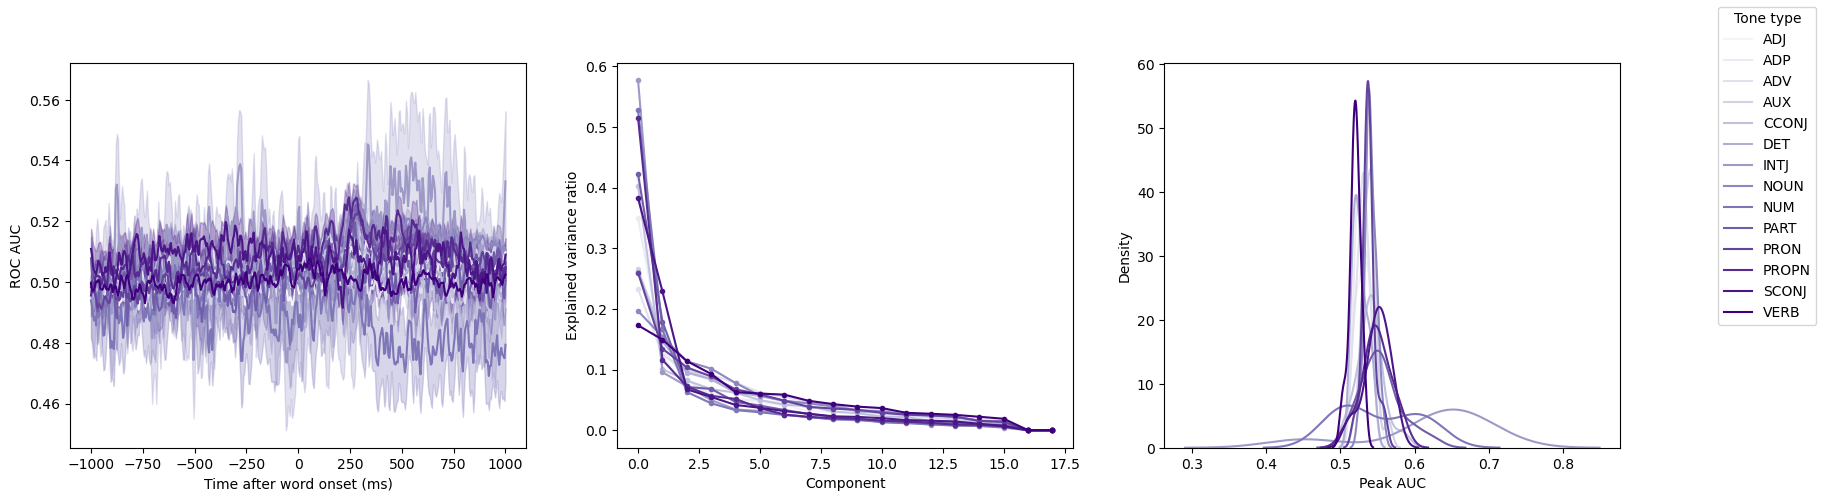

In [49]:
fig, axs = plt.subplots(ncols=3, figsize=(20,5))

classes = pos_types
cmap = mpl.colormaps['Purples']
colors = cmap(np.linspace(0, 1, len(classes) + 1))[1:]

peak_window = [250, 750]


for i, cl in enumerate(classes):
    col = colors[i]
    cl_scores = merged_scores[cl]
    mean = cl_scores.mean(axis=0)
    se = cl_scores.std(axis=0) / np.sqrt(n_subs)
    
    axs[0].plot(t, mean, color=col)
    axs[0].fill_between(t, mean - se, mean + se, color=col, alpha=0.3)
    
    cl_scores_dm = cl_scores - mean

    pca = PCA()
    scores_transformed = pca.fit_transform(cl_scores_dm)
    axs[1].plot(pca.explained_variance_ratio_, marker=".", color=col)
    
    max_around_peak = cl_scores[:,at_t(peak_window[0]):at_t(peak_window[1])].max(axis=-1)
    sns.kdeplot(max_around_peak, label=cl, ax=axs[2], color=col)

axs[0].set_ylabel("ROC AUC")
axs[0].set_xlabel("Time after word onset (ms)")

axs[1].set_ylabel("Explained variance ratio")
axs[1].set_xlabel("Component")

axs[2].set_xlabel("Peak AUC")

fig.legend(title="Tone type")

plt.show()